#**Forecast Airline Delays at Scale with Facebook Prophet and Databricks**:

**Team 5: Priscilla Burity, Andrew Kiruluta, Andreas Lemos, Eric Lundy**


<img src="https://cdn.images.express.co.uk/img/dynamic/25/590x/Flight-delay-The-worst-airline-for-flight-delays-has-been-revealed-1103313.webp?r=1553180527199">

# **THIS MODEL WAS DEVELOPED ON A PROFESSIONAL ACCOUNT ON GOOGLE COLAB RUNNING SPARK 3.1.1 ALL DATA PROVIDED BY THE INSTRUCTORS WAS DOWNLOADED FROM THE KAGGLE WEBSITE AND TRANSFERRED TO GOOGLE DRIVE. IT IS ACCESSED AS FOLLOWS:**

In [ ]:
# mount google drive to access data...
from google.colab import drive  
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

openjdk-8-jdk-headless is already the newest version (8u282-b08-0ubuntu1~18.04).
0 upgraded, 0 newly installed, 0 to remove and 31 not upgraded.


In [ ]:
import pandas as pd
import numpy as np
import itertools
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import plotly.offline as pyoff
import plotly.graph_objs as go
from sklearn import preprocessing
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric
from scipy.stats import boxcox
from scipy.special import inv_boxcox
pd.set_option('display.max_row', 1000)

In [ ]:
# start Spark Session 
from pyspark.sql import SparkSession
app_name = "hw3_notebook"
master = "local[*]"
spark = SparkSession\
        .builder\
        .appName(app_name)\
        .master(master)\
        .getOrCreate()
sc = spark.sparkContext

In [ ]:
# Spark configuration Information 
sc.getConf().getAll()
spark

In [ ]:
# change to directory where data is located
import os
os.chdir("/content/gdrive/My Drive/Airline-Delay-Data/")

In [ ]:
# Read Joined Airline-Weather Spark DataFrame in parquet files into Spark Dataframe
InputPath = ["/content/gdrive/My Drive/Airline-Delay-Data/parquets/*.parquet"]

df_spark = spark.read.parquet(*InputPath)

## **Introduction:**
Time series forecasting is used in multiple business domains, such as pricing, capacity planning, inventory management, etc. Forecasting with techniques such as ARIMA requires the user to correctly determine and validate the model parameters 
$(p,d,q)$. This is a multistep process that requires the user to interpret the Autocorrelation Function (ACF) and Partial Autocorrelation (PACF) plots correctly. Using the wrong model can easily lead to erroneous results.

Prophet is built for business cases typically encounted at Facebook, but which are also encountered in other businesses such as Stackbucks which uses Prophet to predict store demand at Scale using Databricks. These time series typically share the following features:

- Hourly, Daily or Weekly data with sufficient historical data
- Multiple Seasonality patterns related to human behaviour (day of week, seasons)
- Important holidays that are irregularly spaced (Thanksgiving, Chinese New Year, etc.)
- Reasonable amount of missing data
- Historical trend changes
- Non linear growth trends with saturation (capacity limit, etc.)

The goal of Prophet is to product high quality forecasts for decision making out of the box without requiring the user to have expert time series forecasting knowledge. The user can intuitively intervene during the model building process by introducing known parameters such as trend changepoints due to product introduction or trend saturation values due to capacity.

Forecasting with time series models can be used by businesses for many purposes, for example, to optimise sales, improve supply chain planning and perform anomaly detection, to mention a few. There is also a multitude of techniques you can use, from naive extrapolation of historical data to more sophisticated neural network models.

In this work we will leverage Facebooks Prophet to model airline delays as a time series. Prophet is best suited for business-like time series with clear seasonality and where you know important business dates and events beforehand. It is also, like with most time series tools, good to have a data set with observations that span a few years. Both these requirements are satisfied by the data we are working with.

The Prophet library is especially useful for business time series with clear seasonality and the knowledge of special events that have high impact on the data, for example, national holidays with high travel volume such as thankgiving and Christmas in our case. To model time series Prophet separate the signal into the following additive components:

$y(t)=g(t)+s(t)+h(t)+\epsilon_t$

where,
$g(t)$ is the trend function which models non-periodic changes using either a non-linear saturation growth model or a piecewise linear regression model.

$s(t)$ is the seasonal functional (yearly, weekly, daily, hourly) which models the periodic changes in the value of the time series. This component is modelled using a Fourier transform and one can add custom seasonalities.

$h(t)$ represents the function for modelling holidays and special impact events. You can add your own set of custom holidays and special events.

$\epsilon_t$ is the models error/noise which is assumed to be normally distributed.

# **The Approach:**
- Visually inspect the time series data and control for missing data and outliers. This was done earlier in Master Notebook that uses classification to tackle this problem.
-If needed, transform the time series data for stationarity and variance stabilization.
-Make first prediction model without any tuning and validate the model on test data.
-Tune and test the model with the addition of special events dates and holidays.
-Tune and test the model with the addition of other  times series in the data (such as arrival aircraft delays, carrier delay, security delays, weather etc) as additional  regressors in the model.
-Hyperparameter tuning with temporal cross validation with global parameter sweep for each model at scale with spark to obtain the best parameter settings.
-Serve over 6K models (19 carriers * 357 airports = 6783) representing airport/carrier combinatorial time series and generate prediction for each. These 6K models are processed in parallel in Spark using pyspark pandas udf function.


In [ ]:
df = df_spark.toPandas()

In [ ]:
# drop rows with nan
df = df.dropna()
df.head()

,ORIGIN,OP_CARRIER,DEP_DELAY,WEATHER_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,WND_speed_src,VIS_distanceDimension_src,TMP_airTemperature_src,WND_speed_dst,VIS_distanceDimension_dst,TMP_airTemperature_dst,dep_time_utc_for_join
62011,ANC,AS,28.0,1.0,0.0,20.0,15.0,16093.0,56.0,0.0,3219.0,-33.0,2015-09-27 20:00:00
62012,ANC,AS,27.0,0.0,0.0,0.0,15.0,16093.0,206.0,41.0,16093.0,56.0,2016-06-14 22:00:00
62013,ORD,UA,18.0,0.0,0.0,0.0,62.0,16000.0,311.0,0.0,16000.0,194.0,2016-07-12 18:00:00
62014,SEA,DL,47.0,0.0,0.0,0.0,46.0,16093.0,300.0,0.0,16093.0,150.0,2016-08-20 03:00:00
62015,SEA,AS,68.0,0.0,0.0,0.0,41.0,16000.0,150.0,0.0,16000.0,-61.0,2016-10-24 00:00:00


Prophet is expecting columns to have specific names, 'ds' for the temporal part and 'y' for the value part. So we adhere to that. The primary time series we are interested in modeling is the departure delay response variable 'DEP_DELAY' and we will assign that to the 'y' variables. Other time series will thus be treated as additional regressors in the model.

In [ ]:
# Prophet requires the input dataframe’s columns to be named ds and y
df = df.rename(columns={'dep_time_utc_for_join':'ds','DEP_DELAY':'y'})
df.y=df.y.mask(df.y.lt(0),0)
df.head()

,ORIGIN,OP_CARRIER,y,WEATHER_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,WND_speed_src,VIS_distanceDimension_src,TMP_airTemperature_src,WND_speed_dst,VIS_distanceDimension_dst,TMP_airTemperature_dst,ds
62011,ANC,AS,28.0,1.0,0.0,20.0,15.0,16093.0,56.0,0.0,3219.0,-33.0,2015-09-27 20:00:00
62012,ANC,AS,27.0,0.0,0.0,0.0,15.0,16093.0,206.0,41.0,16093.0,56.0,2016-06-14 22:00:00
62013,ORD,UA,18.0,0.0,0.0,0.0,62.0,16000.0,311.0,0.0,16000.0,194.0,2016-07-12 18:00:00
62014,SEA,DL,47.0,0.0,0.0,0.0,46.0,16093.0,300.0,0.0,16093.0,150.0,2016-08-20 03:00:00
62015,SEA,AS,68.0,0.0,0.0,0.0,41.0,16000.0,150.0,0.0,16000.0,-61.0,2016-10-24 00:00:00


In [ ]:
# We need to change the date column from object to datetime format
df['ds'] = df['ds'].astype('datetime64[ns]')

<Figure size 1200x800 with 0 Axes>

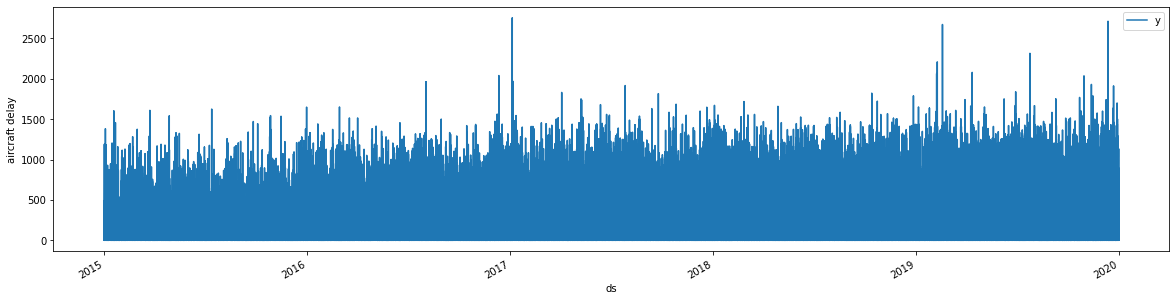

In [ ]:
fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
df.plot(x='ds', y='y', figsize = (20,5), ylabel="aircraft delay")

We can clearly see the seasonality and trend in the time series.

# **Applying Box-Cox Transformation:**

For time-series, it is often useful to do some form of power transform of the data to stabilise variance and make the data more normally distributed. But what transformation to use for the best result? Fortunately, we can use a Box-Cox transformation that evaluates a set of lambda coefficients ($\lambda$) and selects the value that achieves the best approximation of normality. We can do it like this:

In [ ]:
# Apply Box-Cox Transform and save the lambda for later inverse.
from scipy.special import boxcox1p
df['y'] = boxcox1p(df['y'],.5)

<Figure size 1200x800 with 0 Axes>

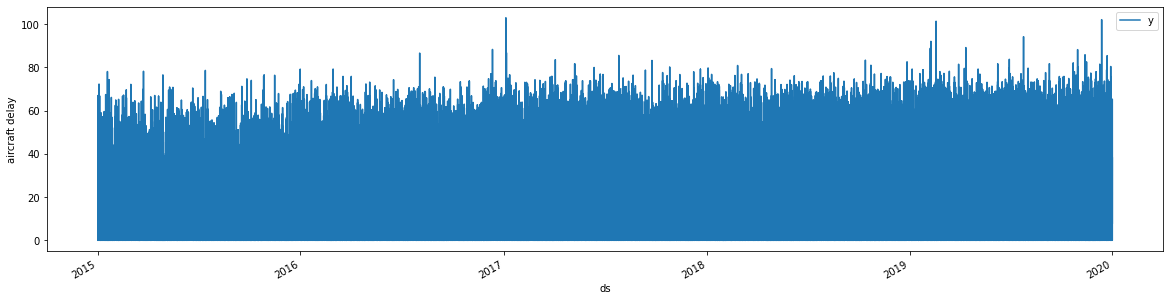

In [ ]:
fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
df.plot(x='ds', y='y', figsize = (20,5), ylabel="aircraft delay")

This should reduce the variance especially around the seasonal peaks.

# **Plotting the weather data**:
Let us  now look at the wind and temperature exploratory variables of the weather as a sample of the seasonlity embedded in these time series. 

<Figure size 1200x800 with 0 Axes>

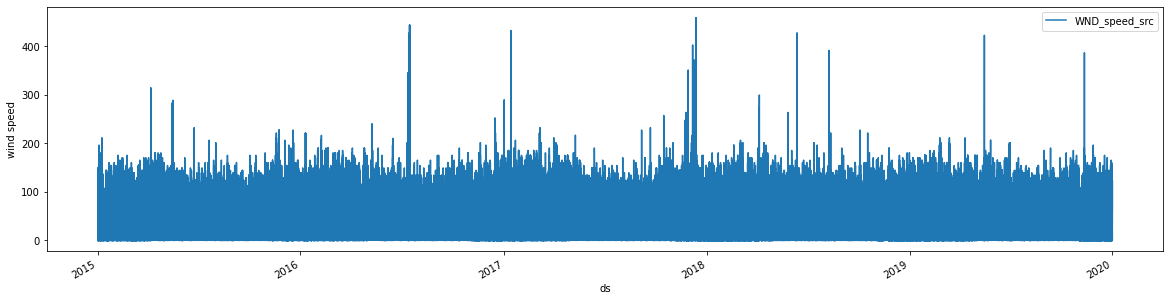

In [ ]:
fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
df.plot(x='ds', y='WND_speed_src', figsize = (20,5), ylabel='wind speed')

<Figure size 1200x800 with 0 Axes>

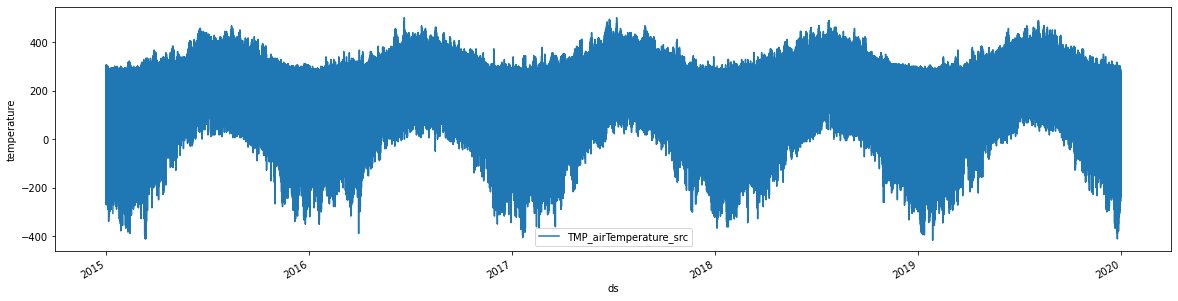

In [ ]:
fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
df.plot(x='ds', y='TMP_airTemperature_src', figsize = (20,5), ylabel='temperature')

# Let us find number of unique carriers in the data: 
Let us group the data per carrier/airport combination and plot the flight delays time series for a sample carrier from a given airport as well as the airport weather sample conditions.

In [ ]:
# list of carriers in the dataframe
carriers = list(df.OP_CARRIER.unique())
len(carriers)

19

In [ ]:
# list of airports in dataframe
airports = set(list(df.ORIGIN))
len(airports)

357

In [ ]:
# Filter Data to one carrier and airport: American and Atlanta as a prototype
carrier_airport = df[(df.OP_CARRIER == 'AA') & (df.ORIGIN == 'ATL')]
carrier_airport.head()
len(carrier_airport)

15526

<Figure size 1200x800 with 0 Axes>

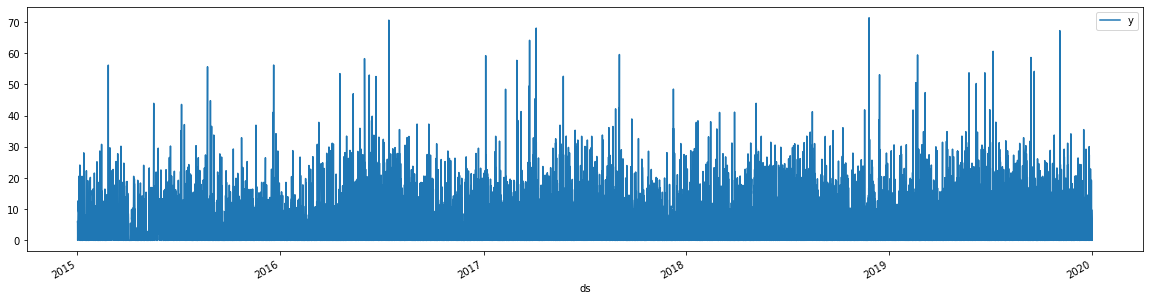

In [ ]:
fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
carrier_airport.plot(x='ds', y='y', figsize = (20,5))
df = carrier_airport

<Figure size 1200x800 with 0 Axes>

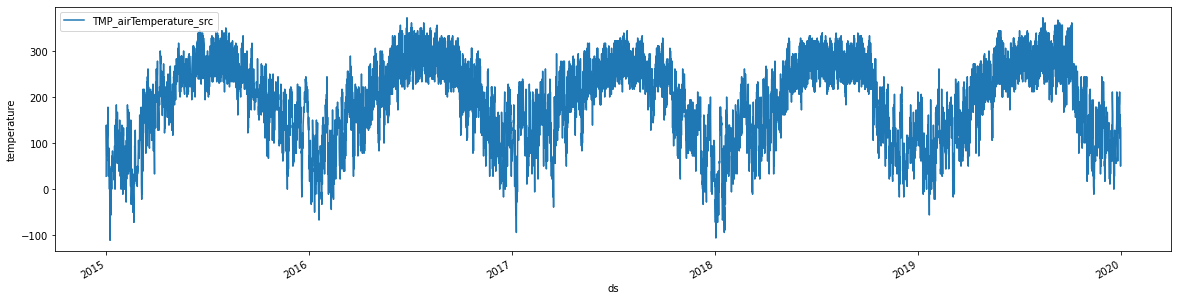

In [ ]:
fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
df.plot(x='ds', y='TMP_airTemperature_src', figsize = (20,5), ylabel='temperature')

We will create some time series features to see how the trends are impacted at intervals of  day of week, hour, time of the month and time of year.

In [ ]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index.
    """
    df = df.copy()
    df['date'] = df['ds']
    df['hour'] = df['ds'].dt.hour
    df['dayofweek'] = df['ds'].dt.dayofweek
    df['quarter'] = df['ds'].dt.quarter
    df['month'] = df['ds'].dt.month
    df['year'] = df['ds'].dt.year
    df['dayofyear'] = df['ds'].dt.dayofyear
    df['dayofmonth'] = df['ds'].dt.day
    df['weekofyear'] = df['ds'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    y = df[label]
    return X, y

X, y = create_features(df, label='y')

features_and_target = pd.concat([X, y], axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.



# Plotting the Features to see trends:

- Airline delays  have strong daily and seasonal properties.
- Day of week also seems to show differences in peaks
- As expected, we also see cyclic events in the week of year splits

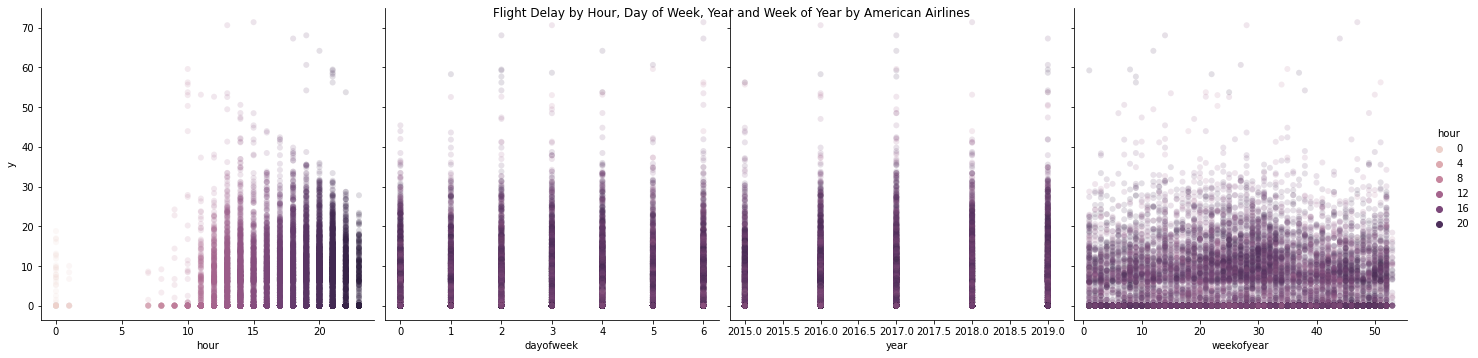

In [ ]:
import seaborn as sns
sns.pairplot(features_and_target.dropna(),
             hue='hour',
             x_vars=['hour','dayofweek',
                     'year','weekofyear'],
             y_vars='y',
             height=5,
             plot_kws={'alpha':0.15, 'linewidth':0}
            )
plt.suptitle('Flight Delay by Hour, Day of Week, Year and Week of Year by American Airlines')
plt.show()

# Train/Test Split:

Cut off the data after 2019-03-15 to use as our test set. We will train on earlier data. The testing set is shown as orange below while our training set is in blue.

In [ ]:
split_date = '2019-03-15'
data = df
data = data.set_index(data.ds)
data.index.names = ['index']
data_train = data.loc[data.index <= split_date].copy()
data_test = data.loc[data.index > split_date].copy()

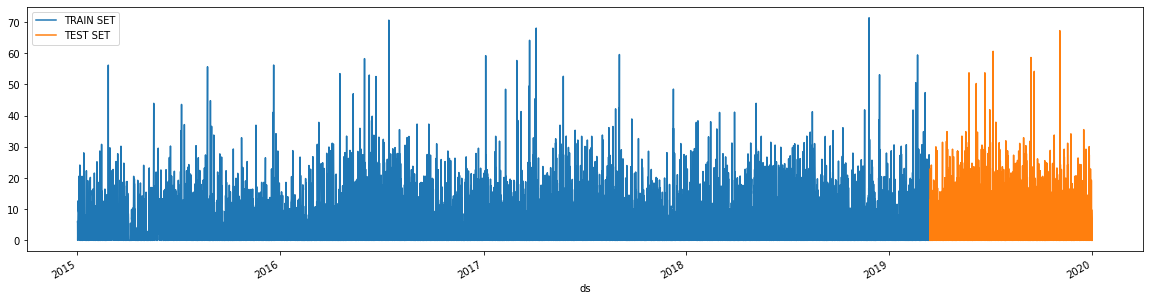

In [ ]:
ax = data_train.rename(columns={'y': 'TRAIN SET'}).plot(x='ds', y='TRAIN SET', figsize = (20,5)) 
data_test.rename(columns={'y': 'TEST SET'}).plot(x='ds', y='TEST SET',ax=ax)

In [ ]:
# Format data for prophet model using ds and y
data_train.reset_index() \
    .rename(columns={'TRAIN SET':'y'}).head(1)

,index,ORIGIN,OP_CARRIER,y,WEATHER_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,WND_speed_src,VIS_distanceDimension_src,TMP_airTemperature_src,WND_speed_dst,VIS_distanceDimension_dst,TMP_airTemperature_dst,ds
0,2017-02-19 14:00:00,ATL,AA,17.493589,0.0,0.0,87.0,46.0,11265.0,128.0,41.0,9656.0,233.0,2017-02-19 14:00:00


# Prophet Model:
Let us model the air passenger arrival data first. The syntax is similar to scikit-learn with calls to the fit and predict functions. We need to make a new data frame for forecasting via the make_future_dataframe function. The parameter freq controls the frequency (e.g. 'H' for days, ‘D’ for days, ‘M’ for months). Our time series is up to a minute resolution so we use hourly for our temporal frequency in the model.

In [ ]:
from fbprophet import Prophet

# instantiate the model and set parameters
model_flight_delay = Prophet(
    interval_width=0.95,
    growth='linear',
    daily_seasonality=True,
    weekly_seasonality=True,
    yearly_seasonality=True,
    seasonality_mode='multiplicative'
)

model_flight_delay = Prophet()
#model = Prophet(yearly_seasonality = True, seasonality_prior_scale=0.1)

# fit the model to historical data
model_flight_delay.fit(data_train)

# make prediction on future flight delays for specific airline
future_flight_delay = model_flight_delay.make_future_dataframe(periods=30, freq='h',include_history=True)
forecast_flight_delay = model_flight_delay.predict(future_flight_delay)

We can plot the forecast by Prophet:

# Forecast Analytics:

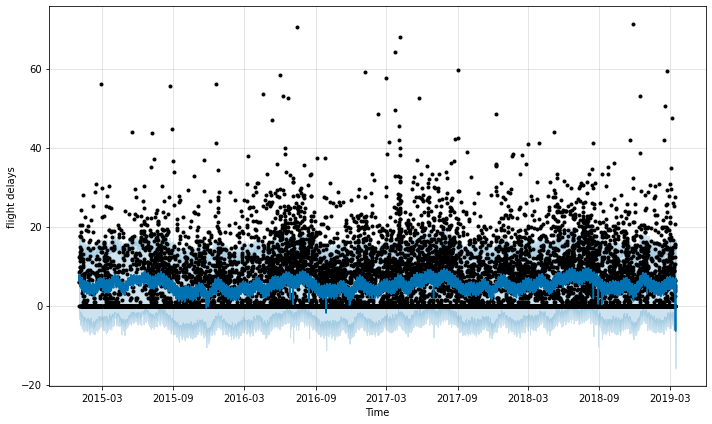

In [ ]:
forecast_plot = model_flight_delay.plot(forecast_flight_delay, xlabel='Time',ylabel='flight delays')

We see that the forecast is not very good and the model struggles to detect the change points - regions of peaks in the delay data. We will address this issue next by modifying the model to account for these abrupt changes.

In [ ]:
forecast_flight_delay.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-01 14:00:00,3.697253,-3.067506,15.362028,3.697253,3.697253,2.454807,2.454807,2.454807,1.875088,1.875088,1.875088,0.229072,0.229072,0.229072,0.350647,0.350647,0.350647,0.0,0.0,0.0,6.152060
1,2015-01-01 16:00:00,3.696624,-2.370842,17.547792,3.696624,3.696624,3.526430,3.526430,3.526430,2.918922,2.918922,2.918922,0.266157,0.266157,0.266157,0.341351,0.341351,0.341351,0.0,0.0,0.0,7.223054
2,2015-01-01 20:00:00,3.695366,-1.090016,17.692727,3.695366,3.695366,4.023266,4.023266,4.023266,3.359291,3.359291,3.359291,0.341300,0.341300,0.341300,0.322675,0.322675,0.322675,0.0,0.0,0.0,7.718632
3,2015-01-02 14:00:00,3.689704,-3.871689,15.700914,3.689704,3.689704,2.659087,2.659087,2.659087,1.875088,1.875088,1.875088,0.546512,0.546512,0.546512,0.237487,0.237487,0.237487,0.0,0.0,0.0,6.348792
4,2015-01-02 18:00:00,3.688446,-1.741898,17.439483,3.688446,3.688446,3.868862,3.868862,3.868862,3.131963,3.131963,3.131963,0.518540,0.518540,0.518540,0.218359,0.218359,0.218359,0.0,0.0,0.0,7.557308


#Trend Change Points:

The trend in a real time series can change abruptly. Prophet attempts to detect these changes automatically using a Laplacian or double exponential prior. By default, the change points are only fitted for the 1st 80% of the time series, allowing sufficient runway for the actual forecast.  These outliers should ideally be removed. Let us display the change points detected by Prophet:

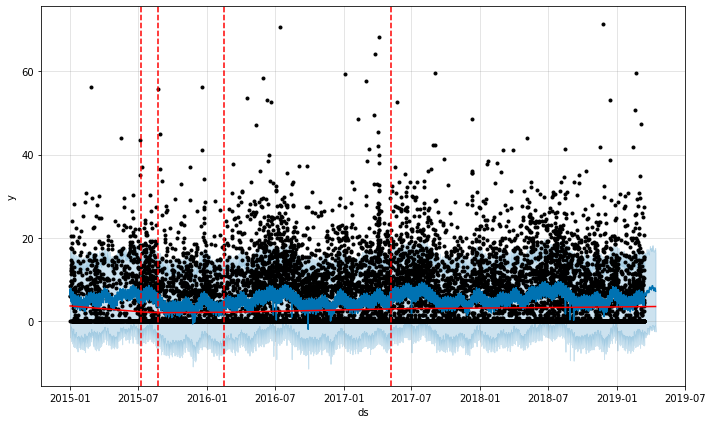

In [ ]:
from fbprophet.plot import add_changepoints_to_plot
flight_delay = model_flight_delay.plot(forecast_flight_delay)
a=add_changepoints_to_plot(flight_delay.gca(),model_flight_delay,forecast_flight_delay)

We see that a lot of change points particulary for the last 20% of the time series are not detected at all. To fix this, we will add holidays that we know affect air travel and hence the potential for delays due the increased traffic and logistics. Fortunately, Prophet has all the world holidays, including the US built in the model and can easily be specified for each country as required. More on this later...

# Plot Model Components:

We get a better fit of the trend when increasing changepoint_prior_scale.  The user can also manually define the change points based on domain knowledge (for example, when forecasting  airline delays, the analyst might be aware of busy travel holidays such as thanksgiving). We can better understand the underlying features of the time series by breaking it into its respective trend and seasonal components.  Using the plot_components function of Prophet, we can display the components of the time series as:

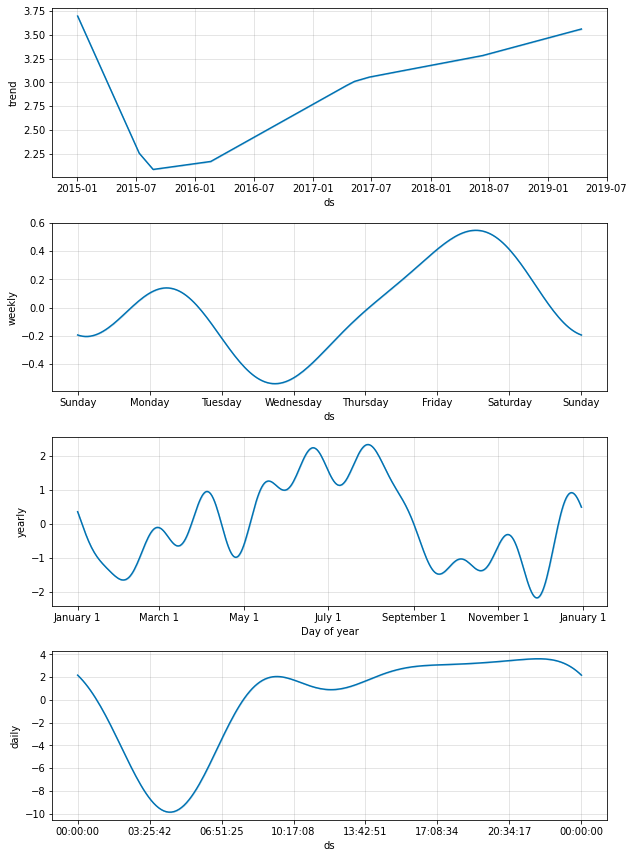

In [ ]:
forecast_components = model_flight_delay.plot_components(forecast_flight_delay)

We observe a piecewise linear trend. Prophet also has the ability to fit saturating trends using a logistic growth trend model. This is applicable in cases where the trend is limited by capacity, for example, the number of airline delays may be limited by the capacity of a given airport.  This is done by setting the parameter growth=logistic and defining a column called cap in the dataframe.

# Temporal Cross Validation:

In order for us to find out how our model performs and know if we are making progress we need some form of validation. We could, of course, write our own validation code, but fortunately we don’t have to, because Prophet provides most of what we need.

The Prophet library makes it possible to divide our historical data into training data and testing data for cross validation. The main concepts for cross validation with Prophet are:

- **Training data (initial)**: The amount of data set aside for training. The parameter is in the API called initial.

- **Horizon**: The data set aside for validation. If we do not  define a period, the model will be fitted with Horizon/2.

- **Cutoff (period)**: a forecast is made for every observed point between cutoff and cutoff + horizon.

The resulting data frame can now be used to compute error measures of $\hat{y}$ vs $y$. We can perform cross validation to measure forecast error. Cut off points are selected and we train the model with data up to that point. We can then compare the prediction vs actual data over a specified time horizon. This can be done using the cross_validation function. The parameter period specifies the interval between cut off points.

In [ ]:
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(model_flight_delay, initial='60 days',
                         period='365 days', horizon = '10 days')

INFO:fbprophet:Making 5 forecasts with cutoffs between 2015-03-05 22:00:00 and 2019-03-04 22:00:00


# **Getting the performance metrics:**

So we have now made our time series forecast with the Prophet library. But how do we know if the results are any good?  Prophet comes with some built-in performance metrics that we can use to measure model performance. The performance metrics available are:

- **mse**: mean absolute error

- **rmse**: mean squared error

- **mae**: Mean average error

- **mape**: Mean average percentage error

- **mdape**: Median average percentage error

The code for validating and gathering performance metrics is shown below. First we need to get the cross validation data (we already did that in the above code listing, it’s the data frame called df_cv )Then we put the cross validation data frame into the Prophet method perfomance_metrics, like so:

df_p = performance_metrics(df_cv)
df_p.head(5)

In [ ]:
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric

df_p = performance_metrics(df_cv)
df_p.head(5)

INFO:fbprophet:Skipping MAPE because y close to 0


,horizon,mse,rmse,mae,mdape,coverage
0,1 days 14:00:00,34.801235,5.899257,4.998031,1.75179,0.948718
1,1 days 15:00:00,35.241402,5.936447,5.125704,inf,0.948718
2,1 days 16:00:00,74.546915,8.634056,5.844525,inf,0.948718
3,1 days 17:00:00,76.398147,8.740603,6.052191,inf,0.923077
4,1 days 18:00:00,75.901016,8.712119,6.045952,inf,0.923077


# RMSE over the Forecast Horizon:

To see how our model performs over time up to the horizon we can use the built-in plot called plot_cross_validation_metric , like this:

plot_cross_validation_metric(df_cv, metric='rmse')

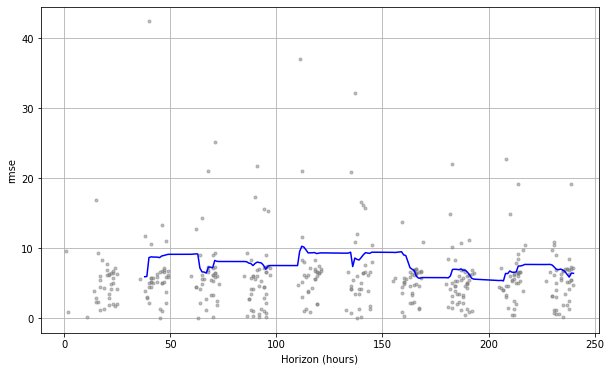

In [ ]:
rmse = plot_cross_validation_metric(df_cv, metric='rmse')

We see that we got forecasts for each day up to the horizon. At the beginning, we see that the mean squared error (mse) jumps around over the forecast horizon. Hopefully we can make this plot more performant as we start tuning our model.

# **Improving our Forecast by Adding Holidays**:

Prophet has several ways of adding holidays and special events. The easiest and most convenient one is to use the built-in national holidays. The holidays for each country are provided by the holidays package in Python. A list of available countries, and the country name to use, is available on the Prophet web page at: https://github.com/dr-prodigy/python-holidays. We need US holidays, so we do it like this:

In [ ]:
model_holidays = Prophet(changepoint_prior_scale=0.25)
model_holidays.add_country_holidays(country_name='US')
model_holidays.fit(data_train)
future_flight_delay = model_holidays.make_future_dataframe(periods=30, freq='D',include_history=True)
forecast = model_holidays.predict(future_flight_delay)
# List the holiday names
model_holidays.train_holiday_names


0                  New Year's Day
1      Martin Luther King Jr. Day
2           Washington's Birthday
3                    Memorial Day
4                Independence Day
5                       Labor Day
6                    Columbus Day
7                    Veterans Day
8                    Thanksgiving
9                   Christmas Day
10       Christmas Day (Observed)
11      New Year's Day (Observed)
12        Veterans Day (Observed)
13    Independence Day (Observed)
dtype: object

# Additional Regressors:

We also explore the option of adding additional regressors or time series to create a vector regression model. This is important for two reasons. One is the fact that the airline delay time series may not be stationary and adding other time series may lead to cointegration and hence co-stationarity. The other reason is to couple in other features that may lead to delays such as security delays and weather related events. Additional regressors can also be discrete like future holidays or another time series. However this time series needs to be known or forecasted separately for future dates.

We use the flight delay data  as the primary regressor and use all other delay metrics such as 'security delays', 'carrier delay', 'arrival delay' as well as weather times series data   as our additional regressors. 

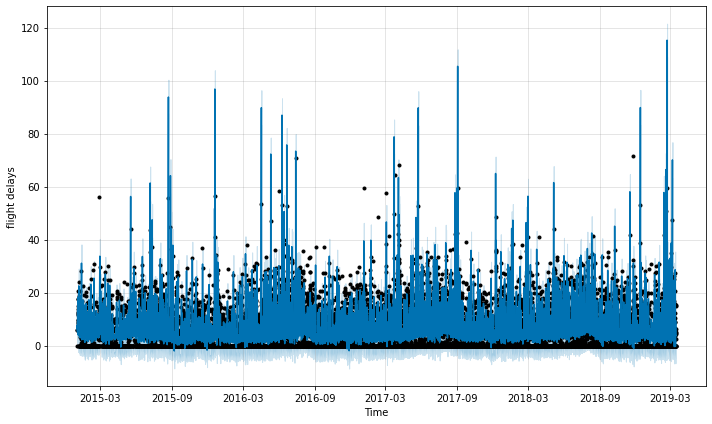

In [ ]:
model_regressors = Prophet(changepoint_prior_scale=0.25)
model_regressors.add_country_holidays(country_name='US')
model_regressors.add_regressor('LATE_AIRCRAFT_DELAY')
model_regressors.add_regressor('SECURITY_DELAY')
model_regressors.add_regressor('WEATHER_DELAY')
model_regressors.add_regressor('TMP_airTemperature_src')
model_regressors.add_regressor('TMP_airTemperature_dst')
model_regressors.add_regressor('VIS_distanceDimension_src')
model_regressors.add_regressor('VIS_distanceDimension_dst')
model_regressors.add_regressor('WND_speed_src')
model_regressors.add_regressor('WND_speed_dst')
model_regressors.fit(data_train)
future = model_regressors.make_future_dataframe(periods=20,freq='D')
future = future.merge(data_train, on='ds')
forecast = model_regressors.predict(future)
fig = model_regressors.plot(forecast, xlabel='Time',ylabel='flight delays')


We notice from these results (black is the original time series while blue is the forecast) that the model now fits the abrupt change pounts in the time series better, including on unseen test data as shown below. The red dots correspond points in the test time series data while in blue is the forecast.

# **Prediction on Unseen Test Data**:

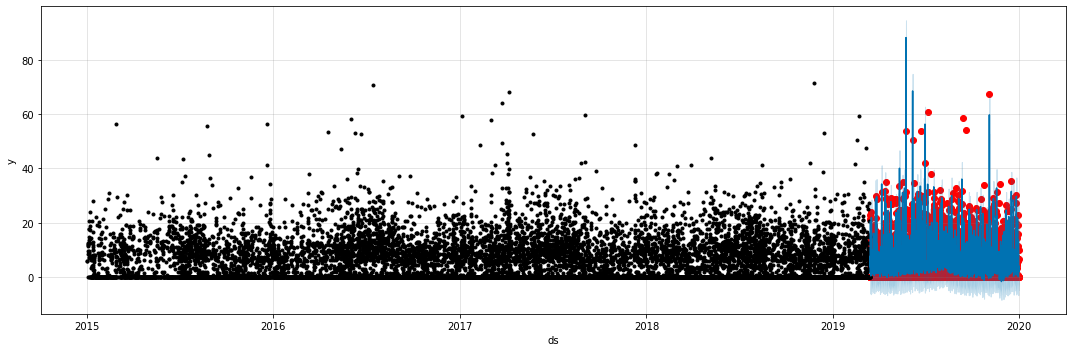

In [ ]:
forecast_test_data = model_regressors.predict(df=data_test.reset_index() \
                                   .rename(columns={'TEST SET':'y'}))
#forecast_plot_test = model_regressors.plot(forecast_test_data, xlabel='Time',ylabel='flight delays')
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(data_test.index, data_test['y'], color='r')
fig = model_flight_delay.plot(forecast_test_data, ax=ax)

In [ ]:
df_cv = cross_validation(model_regressors, initial='30 days',
                         period='365 days', horizon = '7 days')
df_p = performance_metrics(df_cv)
df_p.head(5)

INFO:fbprophet:Making 5 forecasts with cutoffs between 2015-03-08 22:00:00 and 2019-03-07 22:00:00


INFO:fbprophet:Skipping MAPE because y close to 0


,horizon,mse,rmse,mae,mdape,coverage
0,0 days 22:00:00,16.594749,4.073665,3.476174,inf,0.892857
1,0 days 23:00:00,16.203553,4.025364,3.590487,0.59906,0.950000
2,1 days 00:00:00,15.896663,3.987062,3.566669,0.59906,0.964286
3,1 days 01:00:00,16.092378,4.011531,3.593443,inf,0.964286
4,1 days 14:00:00,16.195050,4.024307,3.611021,inf,0.964286


# **Hyperparameters Tuning - Grid Search at Scale**:

Prophet has quite a few parameters to tune. We not going to delve into the details of all of them but given below  is code that  was  used for testing different hyper-parameters for the airport/carrier model combinations in parallel on spark. Remember that if we choose to test all of the parameters in one go,  the number of permutations will be overwhelming and the running time quite  considerable.  To leverage the power of spark, we use the pyspark udf framework to grid search the hyperparameter space for over 6000 models corresponding to the various combinations of airport and carriers. We send the entire dataframe to the spark engine and apply the grid search function to a subset of data grouped by each combination of airport/carrier for a total of well over 6000 different models. This is all implemented in the code block below:

In [ ]:
from pyspark.sql.functions import current_date
from pyspark.sql.functions import pandas_udf, PandasUDFType
def getPerfomanceMetrics(m):
  return performance_metrics(getCrossValidationData(m))

def getCrossValidationData(m):
 return cross_validation(m, initial='30 days', period = '60 days', horizon = '3 days')

def create_param_combinations(**param_dict):
    param_iter = itertools.product(*param_dict.values())
    params =[]
    for param in param_iter:
        params.append(param) 
    params_df = pd.DataFrame(params, columns=list(param_dict.keys()))
    return params_df

def single_cv_run(history_df, metrics, param_dict, parallel):
    m = Prophet(**param_dict)
    m.add_country_holidays(country_name='NO')
    # Adding the extra weather regressors
    m.fit(history_df)
    df_cv = getCrossValidationData(m)
    df_p = performance_metrics(df_cv, rolling_window=1)
    df_p['params'] = str(param_dict)
    df_p = df_p.loc[:, metrics]
    return df_p


pd.set_option('display.max_colwidth', None)
param_grid = {                  
                'changepoint_prior_scale': [0.01],
                'changepoint_range': [0.3],
                'holidays_prior_scale':[1.0],
                'seasonality_prior_scale':[0.5],
                'yearly_seasonality':[20],
                'weekly_seasonality':[5],
               }
metrics = ['horizon', 'rmse', 'mae', 'mape', 'mdape','params'] 
metrics = ['horizon', 'rmse', 'mae', 'mdape','params'] 
results = []



results = (
    AirlineDelayRDD
    .groupby(['OP_CARRIER', 'ORIGIN'])
    .apply(forecast_airport_carrier)
    .withColumn('training_date', current_date())
    )

params_df = create_param_combinations(**param_grid)
params_df = spark.createDataFrame(params_df)

# define output schema
result_schema = StructType([ 
    StructField('ORIGIN', StringType(), True),                         
    StructField('OP_CARRIER', StringType(), True),
    StructField('ds', TimestampType(), True),
    StructField('changepoint_prior_scale', DoubleType(), True),
    StructField('changepoint_range', DoubleType(), True),
    StructField('holidays_prior_scale', DoubleType(), True),
    StructField('seasonality_prior_scale', DoubleType(), True),
    StructField('yearly_seasonality', DoubleType(), True),
    StructField('weekly_seasonality', DoubleType(), True),
    ])

@pandas_udf(result_schema, PandasUDFType.GROUPED_MAP)
def grid_search(history_pd):
  for param in params_df.values:
      param_dict = dict(zip(params_df.keys(), param))
      cv_df = single_cv_run(data_train,  metrics, param_dict, parallel="processes")
      results.append(cv_df)
  results_df = pd.concat(results).reset_index(drop=True)
  best_param = results_df.loc[results_df['rmse'] == min(results_df['rmse']), ['params']]
  print(f'\n The best param combination is {best_param.values[0][0]}')
  return results

params_df = create_param_combinations(**param_grid)
params_df = spark.createDataFrame(params_df)
results_df = (
     params_df
    .groupby(['OP_CARRIER', 'ORIGIN'])
    .apply(grid_search)
    .withColumn('training_date', current_date())
    )
results_df.mean()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 49 forecasts with cutoffs between 2015-02-13 00:00:00 and 2019-03-12 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0




 The best param combination is {'changepoint_prior_scale': 0.01, 'changepoint_range': 0.3, 'holidays_prior_scale': 1.0, 'seasonality_prior_scale': 0.5, 'yearly_seasonality': 20.0, 'weekly_seasonality': 5.0}


horizon    3 days 00:00:00
rmse               68.5257
mae                 38.522
mdape              12.7213
dtype: object

To see if the tuning have any effect we fit a new mode with our new parameters set given above, like this:



In [ ]:
m = Prophet(changepoint_prior_scale=0.01,
            changepoint_range=0.3,
            seasonality_prior_scale=0.5,
            holidays_prior_scale=1.0,
            yearly_seasonality=20,
            weekly_seasonality=5,
            seasonality_mode='additive')

m.add_country_holidays(country_name='US')
m.add_regressor('LATE_AIRCRAFT_DELAY')
m.add_regressor('SECURITY_DELAY')

# Adding the extra weather regressors - TBD
m.add_regressor('WEATHER_DELAY')
#m.add_regressor('temp')
    
m.fit(data_train)
getPerfomanceMetrics(m).mean()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 49 forecasts with cutoffs between 2015-02-13 00:00:00 and 2019-03-12 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0


horizon     2 days 00:00:00
mse             1.75905e+11
rmse                 398915
mae                  129084
mdape               10143.6
coverage           0.947043
dtype: object

# **Plotting and verifying the whole model: Forecast**
The model produced by grid search for each respective combinations of airport/carrier is what is used in the final model for each. For example, the results below show the performance of a given  model for a specific airport/carrier combination with the  overall delays from Atlanta airport by  American Airline planes. Actual American Airline delays from Atlanta airport are shown as the green time series while the forecasted time series from Prophet is shown in blue.

In [ ]:
fig = go.Figure()
# Create and style traces
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat'], name='Prediction',))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['trend'], name='Trend',))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['LATE_AIRCRAFT_DELAY'], name='LATE_AIRCRAFT_DELAY',))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['weekly'], name='Weekly',))
fig.show()


# **Spark DataFrames to Distribute the Processing of Time Series Data**:

We need to predict specific airline carrier delays based on a specific airport. There are about 19 carriers and 357 airports in the data so that we need to serve about 6738 time series models with Prophet. This aspect of the problem leverages the power of Spark on Databricks to service and update these time series models in parallel. We can use Spark to distribute the training of these airline delay  models for each airport and per unique carrier, making it possible to predict not just overall airline departure delays across the US, but the unique departure delay for each carrier coming out of each airport in the country. 

Our goal is to generate not one forecast for the entire dataset, but thousands of models and forecasts for each airport-carrier combination, something that would be incredibly time consuming to perform as a sequential operation.

# **Leveraging the power of Pandas User-Defined Functions (UDFs):**

With our time series data properly grouped by airport and carrier, we now need to train a single model for each group. To accomplish this, we can use a pandas User-Defined Function (UDF), which allows us to apply a custom function to each group of data in our DataFrame.

This UDF will not only train a model for each group, but also generate a result set representing the predictions from that model. But while the function will train and predict on each group in the DataFrame independent of the others, the results returned from each group will be conveniently collected into single resulting DataFrame. This will allow us not only to generate airport-carrier level forecasts but present our results to analysts and managers as a single output dataset.

The key mechanism for achieving distributed data processing in Spark is the DataFrame. By loading the data into a Spark DataFrame, the data is distributed across  workers in the cluster. This allows these workers to process subsets of the data in a parallel manner, reducing the overall amount of time required to perform our work.

Each worker needs to have access to the subset of data it requires to do its work. By grouping the data on key values, in this case on combinations of airport and carrier, we bring together all the time series data for those key values onto a specific worker node.

```
airport_carrier_history
    .groupBy('Airport', 'Carrier')
     #. . .
```
With our time series data properly grouped by airport and carrier, we now need to train a single model for each group. To accomplish this, we can use a pandas UDF, which allows us to apply a custom function to each group of data in our DataFrame.

This UDF will not only train a model for each group, but also generate a result set representing the predictions from that model. 
The UDF is instantiated with the pandas_udf method which identifies the schema of the data it will return and the type of data it expects to receive. Immediately following this, we define the function that will perform the work of the UDF. Within the function definition, we instantiate our model, configure it and fit it to the data it has received. The model makes a prediction, and that data is returned as the output of the function.


In [ ]:
from pyspark.sql.types import StructType,StructField,StringType,TimestampType,ArrayType,DoubleType
from pyspark.sql.functions import current_date
from pyspark.sql.functions import pandas_udf, PandasUDFType

# define output schema
result_schema = StructType([ 
    StructField('ORIGIN', StringType(), True),                         
    StructField('OP_CARRIER', StringType(), True),
    StructField('ds', TimestampType(), True),
    StructField('trend', DoubleType(), True),
    StructField('trend_upper', DoubleType(), True),
    StructField('trend_lower', DoubleType(), True),
    StructField('daily', DoubleType(), True),
    StructField('daily_upper', DoubleType(), True),
    StructField('daily_lower', DoubleType(), True),
    StructField('weekly', DoubleType(), True),
    StructField('weekly_upper', DoubleType(), True),
    StructField('weekly_lower', DoubleType(), True),
    StructField('yearly', DoubleType(), True),
    StructField('yearly_upper', DoubleType(), True),
    StructField('yearly_lower', DoubleType(), True),
    StructField('yhat', DoubleType(), True),
    StructField('yhat_upper', DoubleType(), True),
    StructField('yhat_lower', DoubleType(), True),
    StructField('multiplicative_terms', DoubleType(), True),
    StructField('multiplicative_terms_upper', DoubleType(), True),
    StructField('multiplicative_terms_lower', DoubleType(), True),
    StructField('additive_terms', DoubleType(), True),
    StructField('additive_terms_upper', DoubleType(), True),
    StructField('additive_terms_lower', DoubleType(), True),

    ])

@pandas_udf(result_schema, PandasUDFType.GROUPED_MAP)
def forecast_airport_carrier(history_pd):

    # instantiate the model, configure the parameters
    model = Prophet(
        interval_width=0.95,
        growth='linear',
        daily_seasonality=True,
        weekly_seasonality=True,
        yearly_seasonality=True,
        seasonality_mode='multiplicative'
    )

    # fit the model
    model.fit(history_pd)

    # configure predictions
    future_pd = model.make_future_dataframe(
        periods=90,
        freq='h',
        include_history=True
    )

    # make predictions
    results_pd = model.predict(future_pd)
    results_pd = pd.concat([results_pd,history_pd['OP_CARRIER']],axis = 1)
    results_pd = pd.concat([results_pd,history_pd['ORIGIN']],axis = 1)
    # . . .

    # return predictions
    return results_pd

Now, to bring it all together, we use the groupBy command we discussed earlier to ensure our dataset is properly partitioned into groups representing specific airport and carrier combinations. We then simply apply the UDF to our DataFrame, allowing the UDF to fit a model and make predictions on each grouping of data.

The dataset returned by the application of the function to each group is updated to reflect the date on which we generated our predictions. This will help us keep track of data generated during different model runs if we eventually take our functionality into production.

In [ ]:
from pyspark.sql.functions import current_date
from pyspark.sql.functions import pandas_udf, PandasUDFType
AirlineDelayRDD = spark.createDataFrame(data_train)
results = (
    AirlineDelayRDD
    .groupby(['OP_CARRIER', 'ORIGIN'])
    .apply(forecast_airport_carrier)
    .withColumn('training_date', current_date())
    )

# **Airport/Carrier Models Predictive Analytics**:

In [ ]:
df3 = results.toPandas())
df3[['ORIGIN','OP_CARRIER','ds','yhat_lower', 'yhat','yhat_upper', 'training_date']].head()

,ORIGIN,OP_CARRIER,ds,yhat_lower,yhat,yhat_upper,training_date
0,ATL,AA,2015-01-01 14:00:00,-7.981146,6.298720,20.723988,2021-04-14
1,ATL,AA,2015-01-01 16:00:00,-6.340332,7.678027,22.610928,2021-04-14
2,ATL,AA,2015-01-01 20:00:00,-6.922770,8.221218,22.625254,2021-04-14
3,ATL,AA,2015-01-02 14:00:00,-9.128199,6.587629,21.585753,2021-04-14
4,ATL,AA,2015-01-02 18:00:00,-4.992193,8.018543,22.359748,2021-04-14


# **Conclusion**:

In this work, we have explored the formulation of airline delay prediction as  a time series forecasting problem. In this regard, we have explored the use the Facebook Prophet library to make time series forecasts. To reduce the variance in time series and help with moving the underlying statistics towards a normal distribution, we  used a Box Cox transformation.  We also added  extra regressors to aid with making the series stationary through cointegration and fine tuned Prophet models to perform increasingly better. Because Prophet has a lot of parameters to tune and we have a lot of models (>6K) corresponding to the combinations of departure airports/carriers, we leveraged the power of Spark through pandas  udf framework to parallelize the grid search of optimal hyperparameters for all the models. We started out with a mean percentage average error of ~17% and ended up with ~5%, a considerable improvement and a usable result. 

To leverage the power of spark by serving a time series prediction model per carrier for each specific airport in the dataset, we also parallelized the training and prediction task of  6K plus models with Spark. We have  constructed a time series forecasting model for each airport-carrier combination that outputs a spreadsheet of the hourly prediction per carrier/departure airport pair in the dataset. Using an SQL query, analysts can view the tailored forecasts for each airport/carrrier combination to within an hour of each flight departure. 

In this course, we learned how to parallerize big data and do processing on individual chunks over many computer clusters. In this work, we have demonstrated using the spark framework to parallelize the train of thousands of models in a cluster environment and generate forecasts in parallel for all the models stored in an easily accessed on-time demand spreadsheet that is continually updated as new data is gathered and processed.